# Multicriterion optimization

In this notebook we explore some of the multicriterion optimization problems we saw in class, including regularized least-squares (a.k.a. ridge regression), risk return trade-offs in portfolio optimization, and minimal upper bounds on a set of matrices.

## Regularized least squares

Here we consider solving the multicriterion optimization problem, with respect to $\mathbb{R}^2_+$ of $(\|Ax-b\|_2^2,\|x\|_2^2)$.  To do so, we apply scalarization by drawing elements $\lambda$ from the interior of the dual cone, which in this case is $\mathbb{R}^2_{++}$, resulting in the scalar QP problem $$\mathrm{minimize}_{x} \lambda_1\|Ax-b\|_2^2 + \lambda_2 \|x\|_2^2,$$ for $\lambda_1$, $\lambda_2 > 0$.

By suitably renormalizing, this problem is equivalent to
$$\mathrm{minimize}_{x} \theta\|Ax-b\|_2^2 + (1-\theta) \|x\|_2^2,$$
for $\theta \in (0,1)$.

In [176]:
import cvxpy as cp
import numpy as np
from multiprocessing import Pool
import time

# set up the problem parameters
np.random.seed(10)

m = 10
n = 2

A = np.random.randn(m,n)
b = np.random.randn(m)

# set up the gridding for theta
theta_vals = np.linspace(0,1,num=100)

# set up the optimzation problem
x = cp.Variable(n)
theta = cp.Parameter(nonneg=True) # theta >= 0 to satisfy DCP rules

# set up the two objective terms
least_squares = cp.sum_squares(A @ x - b)
x_norm = cp.sum_squares(x)


#construct the weighted sum
objective = cp.Minimize(theta * least_squares + cp.abs(1 - theta) * x_norm) 
# need cp.abs(1-theta) to tell DCP that  (1-theta) will always be non-neg
prob = cp.Problem(objective)

In [186]:
# set up function to get answer for multi-threading
def get_optimal_value(theta_value):
    theta.value = theta_value
    result = prob.solve()
    return [least_squares.value,x_norm.value]

# flag for using multi-threading or not
use_pool = True

pareto_curve = []

# use multi-threading because Python lets us
if use_pool:
    # use a context manager to esnure that processing join and close are doine in proper order
    with Pool(processes = 16) as pool:
        start = time.time()
        pareto_curve = pool.map(get_optimal_value, theta_vals)
        print("elapsed time: {}".format(time.time()-start))
else:
    for this_theta in theta_vals:
        pareto_curve.append(get_optimal_value(this_theta))

pareto_curve = np.asarray(pareto_curve)

elapsed time: 0.1307370662689209


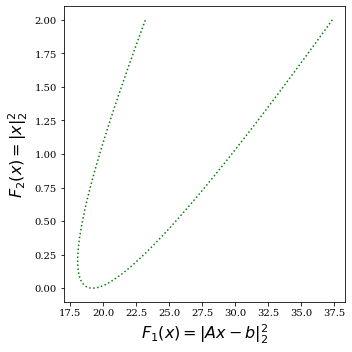

In [187]:
# now let's visualize our results
import matplotlib.pyplot as plt

plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.figure(figsize=(5,5))

# Plot pareto curve
plt.subplot(111)

plt.plot(pareto_curve[:,0],pareto_curve[:,1])
plt.xlabel(r'$F_1(x)=\|Ax - b\|_2^2$', fontsize=16)
plt.ylabel(r'$F_2(x)=\|x\|_2^2$', fontsize=16)

# Plot approximation of achievable values
x1_vals = np.linspace(-1,1,1000)
x2_vals = np.linspace(-1,1,1000)

ls = lambda x : np.inner(A @ x - b, A @ x - b)
xn = lambda x : np.inner(x,x)

ls_vals = []
xn_vals = []
for x1, x2 in zip(x1_vals, x2_vals):
    xx = [x1,x2]
    ls_vals.append(ls(xx))
    xn_vals.append(xn(xx))

plt.plot(ls_vals,xn_vals,'g:')

plt.tight_layout()
plt.show()

## Risk return trade-off in portfolio optimization

In this problem, we seek to maximize the risk-adjusted return of an investment portoflio.  Recall that we model our portfolio in terms of:

- $x \in \mathbb{R}^n$ the investment portfolio, with $x_i$ the fraction invested in asset $i$.  An investment $x_i\geq 0$ represents a long position and an investment $x_i < 0$ represents a short position.
- $p \in \mathbb{R}^n$ is the vector of relative asset price changes; we model this as a random variable with mean $\mathbb E p = \bar p$ and covariance $\mathbb E (p-\bar p)(p-\bar p)^\top = \Sigma$.
- The return of our portfolio, $r = p^\top x$ is consequently a random variable with expected return $\mathbb E r = \bar{p}^\top x$ and variance $\mathrm{var}(r) = x^\top \Sigma x$.

We consider the simplest possible variation of this problem, wherein we normalize our budget to one, as captured by the constraint $\boldsymbol{1}^\top x = 1$, and disallow short positions by constraining $x \succeq 0$.  We may then formulate our multicriterion optimization problem, with respect to $\mathbb{R}^2_+$ as
$$ \begin{array}{rl} \mathrm{maximize}_x & (\bar{p}^\top x, -x^\top \Sigma x) \\
\text{subject to} & \boldsymbol{1}^\top x = 1, \ x\succeq 0 \end{array}, $$
which, after scalarization and renormalization, becomes, 
$$ \begin{array}{rl} \mathrm{maximize}_x & \theta\bar{p}^\top x - (1-\theta)x^\top \Sigma x) \\
\text{subject to} & \boldsymbol{1}^\top x = 1, \ x\succeq 0 \end{array}, $$
for some $\theta \in (0,1)$

In [188]:
import cvxpy as cp
import numpy as np
from multiprocessing import Pool
import time

# set up the problem parameters
np.random.seed(10)

n = 10

s = np.random.randn(n,n)
Sigma = s.T @ s
pbar = 0.5 + 0.5 * np.random.rand(n)

# set up the gridding for theta
theta_vals = np.linspace(0,1,num=100)

# set up the optimzation problem
x = cp.Variable(n)
theta = cp.Parameter(nonneg=True) # theta >= 0 to satisfy DCP rules

# set up the two objective terms
mean_return = pbar.T @ x
risk = cp.quad_form(x,Sigma)

# set up the constraints
constraints = [cp.sum(x) == 1,
               x >= 0]

#construct the weighted sum
objective = cp.Maximize(theta * mean_return - cp.abs(1-theta) * risk) 
# need cp.abs(1-theta) to tell DCP that  (1-theta) will always be non-neg
prob = cp.Problem(objective, constraints)

In [189]:
# set up function to get answer for multi-threading
def get_optimal_value(theta_value):
    theta.value = theta_value
    result = prob.solve()
    return [mean_return.value,np.sqrt(risk.value),x.value]

# flag for using multi-threading or not
use_pool = True

pareto_curve = []

# use multi-threading because Python lets us
if use_pool:
    # use a context manager to esnure that processing join and close are doine in proper order
    with Pool(processes = 16) as pool:
        start = time.time()
        pareto_curve = pool.map(get_optimal_value, theta_vals)
        print("elapsed time: {}".format(time.time()-start))
# or don't
else:
    for this_theta in theta_vals:
        pareto_curve.append(get_optimal_value(this_theta))

pareto_curve = np.asarray(pareto_curve)

elapsed time: 0.13603830337524414


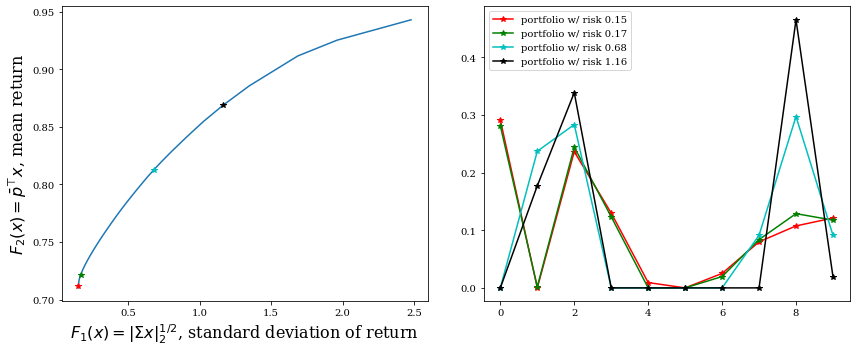

In [190]:
# now let's visualize our results
import matplotlib.pyplot as plt

plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.figure(figsize=(12,5))

# Plot pareto curve
plt.subplot(121)

plt.plot(pareto_curve[:,1],pareto_curve[:,0])
plt.xlabel(r'$F_1(x)=\|\Sigma x\|_2^{1/2}$, standard deviation of return', fontsize=16)
plt.ylabel(r'$F_2(x)=\bar{p}^\top x$, mean return', fontsize=16)

# Pick out four points along the curve and plot the resulting allocations 
pf1 = pareto_curve[10,:]
pf2 = pareto_curve[50,:]
pf3 = pareto_curve[90,:]
pf4 = pareto_curve[95,:]
plt.plot(pf1[1],pf1[0],'r*')
plt.plot(pf2[1],pf2[0],'g*')
plt.plot(pf3[1],pf3[0],'c*')
plt.plot(pf4[1],pf4[0],'k*')

# And plot out their corresponding allocations
plt.subplot(122)

plt.plot(range(n),pf1[2],'r*-')
plt.plot(range(n),pf2[2],'g*-')
plt.plot(range(n),pf3[2],'c*-')
plt.plot(range(n),pf4[2],'k*-')

plt.legend(("portfolio w/ risk {0:.2f}".format(pf1[1]),"portfolio w/ risk {0:.2f}".format(pf2[1]),\
           "portfolio w/ risk {0:.2f}".format(pf3[1]),"portfolio w/ risk {0:.2f}".format(pf4[1])))

plt.tight_layout()
plt.show()

# Minimal Upper Bound on a Set of Matrices

We consider the (convex) vector optimizationproblem, with respect to $\mathbb{S}^n_+$,
\begin{equation*}
\label{eq:matrixopt}\tag{1}
\begin{array}{rl} \mathrm{minimize} & X \\
\text{subject to} &  X \succeq A_i, \ i=1,\dots,m,\end{array}\end{equation*}
where the $A_i \in \mathbb{S}^n$, $i=1,\dots,m$ are given.  The constraints mean that $X$ is an upper bound on the matrices $A_1,\dots,A_m$; a Pareto optimal solution to $\eqref{eq:matrixopt}$ is a _minimial upper bound_ on the matrices.

To find a Pareto optimal point, we apply scalarization: $\mathbb{S}^n_+$ is self-dual, and hence we select an element $W \in \mathbb{S}^n_{++}$ and form the problem (recalling that the inner product on $\mathbb{S}^n$ is defined as $\mathrm{Tr}XY$:
\begin{equation*}
\label{eq:matrixopt2}\tag{2}
\begin{array}{rl} \mathrm{minimize} & \mathrm{Tr}WX \\
\text{subject to} &  X \succeq A_i, \ i=1,\dots,m,\end{array}\end{equation*}
which is an SDP.  Different choices of $W$, will in general, give different minimal solutions.

We can give a simple geometric interpretation for this problem if we assume that each $A_i \in \mathbb{S}^n_{++}$.  We associate with each $A\in \mathbb{S}^n_{++}$ an ellipsoid centered at the origin, given by 
$$ \mathcal{E}_A = \left\{u \, | \, u^\top A^{-1} u \leq 1 \right\}, $$
so that $A \preceq B$ if and only if $\mathcal{E}_A \subseteq \mathcal{E}_B$.  With this geometric picture in mind, a Pareto optimal $X$ is one which corresponds to a minimal ellipsoid that contains the ellipsoids associated with $A_1,\dots,A_m$.

In [191]:
import cvxpy as cp
import numpy as np
from multiprocessing import Pool
import time

# set up the problem parameters
np.random.seed(10)

n = 2
m = 8

# Set up constraint variables Ai
As = []
for i in range(m):
    a = np.random.randn(n,n)
    As.append(a.T @ a)

# Set up some random directions in S^n_++ to optimize in
k = 5
Ws = []
for i in range(k):
    w = np.random.randn(n,n)
    Ws.append(w.T @ w)


# set up the optimzation problem
X = cp.Variable((n,n), PSD=True)
W = cp.Parameter((n,n), PSD=True) 

#set up objective
objective = cp.Minimize(cp.trace(W @ X))

# set up the constraints
constraints = [X >> 0]
for Ai in As:
    constraints += [X >> Ai]

prob = cp.Problem(objective, constraints)

In [192]:
# set up function to get answer for multi-threading
def get_optimal_value(W_value):
    W.value = W_value
    result = prob.solve()
    return X.value

# flag for using multi-threading or not
use_pool = False

Xs = []

# use multi-threading because Python lets us
if use_pool:
    # use a context manager to esnure that processing join and close are doine in proper order
    with Pool(processes = 16) as pool:
        start = time.time()
        Xs = np.asarray(pool.map(get_optimal_value, Ws))
        print("elapsed time: {}".format(time.time()-start))
else:
    for this_W in Ws:
        Xs.append(get_optimal_value(this_W))

Xs = np.asarray(Xs)

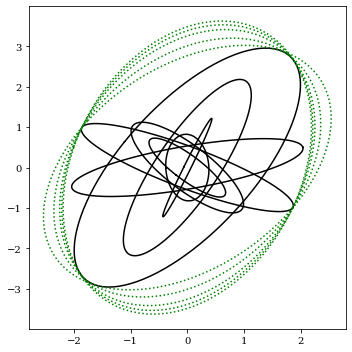

In [193]:
# Now let's plot the ellipses
import matplotlib.pyplot as plt

def ellipse(E):
    V, W = np.linalg.eig(E)
    Asqrtm = W @ np.sqrt(np.diag(V))
    t = np.linspace(0, 2*np.pi, num=100)
    z = [np.cos(t), np.sin(t)]
    return Asqrtm @ z


plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.figure(figsize=(5,5))

# First let's start with the constraint ellipsoids
for Ai in As:
    ell = ellipse(Ai)
    plt.plot(ell[0,:],ell[1,:],'k')
    
# And now let's plot the different Pareto optimal solutions that we found
for X in Xs:
    ell = ellipse(X)
    plt.plot(ell[0,:],ell[1,:],'g:')
    
plt.tight_layout()
plt.show()